### Importing Necessary Libraries

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.utils import to_categorical
import cv2
import PIL.Image as Image
import os
import random
import glob
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Exploratory Data Analysis

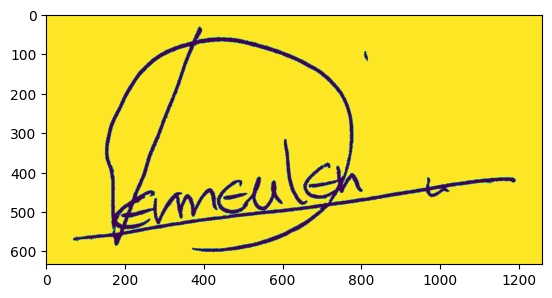

In [ ]:
dataset_path = '/content/drive/MyDrive/Dataset_sign'
img = plt.imread('/content/drive/MyDrive/Dataset_sign/dataset4/forge/00301002.png')
plt.imshow(img)

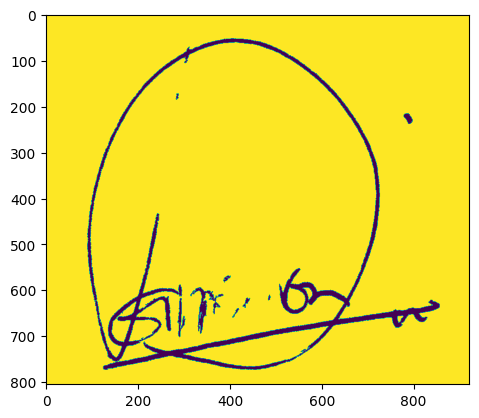

In [ ]:
img1 = plt.imread('/content/drive/MyDrive/Dataset_sign/dataset4/real1/00201002.png')
plt.imshow(img1)

In [3]:
IMAGE_SHAPE = (224,224)
real_signs = [
       glob.glob('/content/drive/MyDrive/Dataset_sign/dataset1/real/*.*'),
       glob.glob('/content/drive/MyDrive/Dataset_sign/dataset2/real/*.*'),
       glob.glob('/content/drive/MyDrive/Dataset_sign/dataset3/real/*.*'),
       glob.glob('/content/drive/MyDrive/Dataset_sign/dataset4/real1/*.*')]

forged_signs = [
        glob.glob('/content/drive/MyDrive/Dataset_sign/dataset1/forge/*.*'),
        glob.glob('/content/drive/MyDrive/Dataset_sign/dataset2/forge/*.*'),
        glob.glob('/content/drive/MyDrive/Dataset_sign/dataset3/forge/*.*'),
        glob.glob('/content/drive/MyDrive/Dataset_sign/dataset4/forge/*.*')
]

### Data Preprocessing

In [42]:
training_data=[]
training_labels=[]
testing_data = []
train_paths=[]
testing_labels=[]
test_paths=[]
for data in range(len(real_signs)):
   for it in real_signs[data]:
    image = cv2.imread(it)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    resized_img = cv2.resize(image,IMAGE_SHAPE)
    if data==3:
      test_paths.append(it)
      testing_data.append(resized_img)
      testing_labels.append(0)  #0 stands for real signs
    else:
      train_paths.append(it)
      training_data.append(resized_img)
      training_labels.append(0)
for data in range(len(forged_signs)):
  for it in forged_signs[data]:
    image= cv2.imread(it)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    resized_img = cv2.resize(image,IMAGE_SHAPE)
    if data==3:
      testing_data.append(resized_img)
      test_paths.append(it)
      testing_labels.append(1)  #1 stands for forged signs
    else:
      training_data.append(resized_img)
      train_paths.append(it)
      training_labels.append(1)


In [43]:
training_data = np.array(training_data)
testing_data = np.array(testing_data)
training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

In [47]:
print(testing_labels[:20])
print(training_labels[:20])

[[1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]


In [45]:
training_data = training_data/255.0
testing_data = testing_data/255.0
num_train = sum([len(x) for x in training_data])
num_test = sum([len(x) for x in testing_data])
print(f"Training data length: {num_train}")
print(f"Testing data length: {num_test}")

Training data length: 120960
Testing data length: 40320


In [ ]:
def load_images(file_list):
    images = []
    for files in file_list:
        for file in files:
            img = cv2.imread(file)
            images.append(img)
    return images

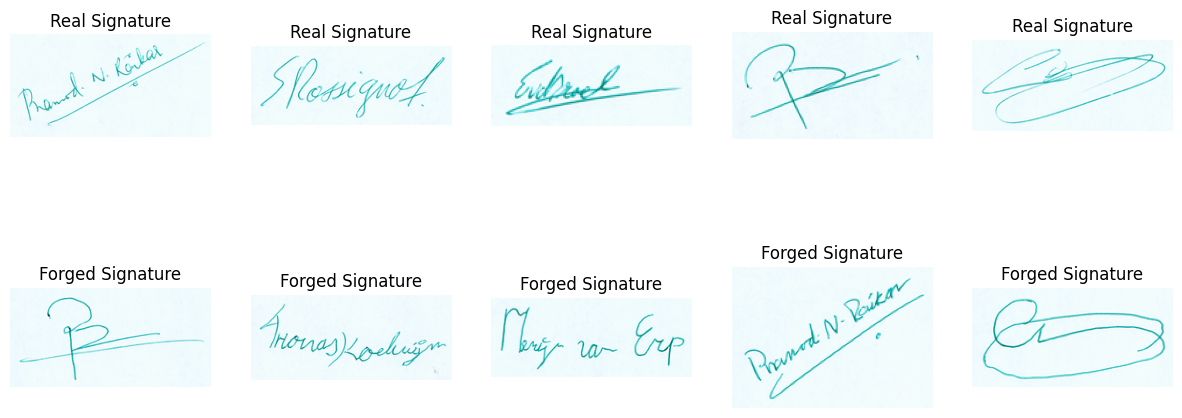

In [ ]:
gen_imgs = load_images(real_signs)
forg_imgs = load_images(forged_signs)
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i in range(5):
    axs[0, i].imshow(cv2.cvtColor(gen_imgs[i], cv2.COLOR_BGR2RGB))
    axs[0, i].set_title("Real Signature")
    axs[0, i].axis("off")

    axs[1, i].imshow(cv2.cvtColor(forg_imgs[i], cv2.COLOR_BGR2RGB))
    axs[1, i].set_title("Forged Signature")
    axs[1, i].axis("off")

plt.show()

In [46]:
from sklearn.utils import shuffle
training_labels = to_categorical(training_labels)
testing_labels = to_categorical(testing_labels)
training_data,training_labels,train_paths = shuffle(training_data,training_labels,train_paths)
testing_data,testing_labels,test_paths = shuffle(testing_data,testing_labels,test_paths)

In [48]:
binary_labels = training_labels[:, 0]
binary_labels = 1 - binary_labels

In [49]:
flattened_data = training_data.reshape((training_data.shape[0], -1))

In [50]:
flattened_test = testing_data.reshape((testing_data.shape[0], -1))
binary_test_labels = testing_labels[:, 0]
binary_test_labels = 1 - binary_test_labels

### Logistic Regression

In [51]:
lrmodel = LogisticRegression(max_iter=1000)
lrmodel.fit(flattened_data,binary_labels)

LogisticRegression(max_iter=1000)

In [ ]:
training_data.shape

(540, 224, 224, 3)

In [52]:
predictions = lrmodel.predict(flattened_test)
from sklearn.metrics import accuracy_score
# Evaluate the model
accuracy = accuracy_score(binary_test_labels, predictions)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.71


Text(95.72222222222221, 0.5, 'Truth')

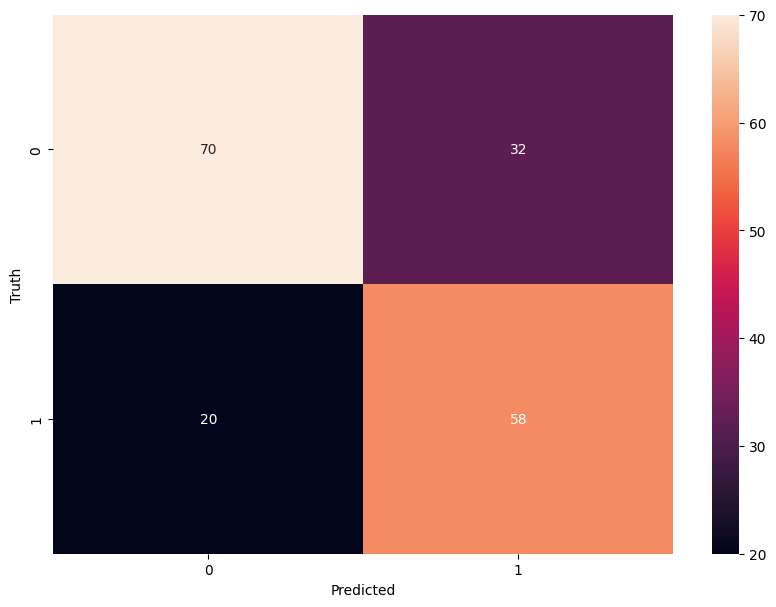

In [53]:
cm = confusion_matrix(predictions,binary_test_labels)
plt.figure(figsize=(10,7))
sns.heatmap(cm,annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [54]:
print(classification_report(binary_test_labels,predictions))

              precision    recall  f1-score   support

         0.0       0.69      0.78      0.73        90
         1.0       0.74      0.64      0.69        90

    accuracy                           0.71       180
   macro avg       0.71      0.71      0.71       180
weighted avg       0.71      0.71      0.71       180



In [55]:
pred = lrmodel.predict(flattened_test)
pred[:20]

array([0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0.,
       0., 1., 0.], dtype=float32)

In [56]:
for i in range(20):
  print('Person ',i,' \n Predicted: ',pred[i],' Actual: ',binary_test_labels[i],'path: ',test_paths[i])

Person  0  
 Predicted:  0.0  Actual:  0.0 path:  /content/drive/MyDrive/Dataset_sign/dataset4/real1/09203092.png
Person  1  
 Predicted:  0.0  Actual:  1.0 path:  /content/drive/MyDrive/Dataset_sign/dataset4/forge/06103016.png
Person  2  
 Predicted:  0.0  Actual:  0.0 path:  /content/drive/MyDrive/Dataset_sign/dataset4/real1/09304093.png
Person  3  
 Predicted:  0.0  Actual:  0.0 path:  /content/drive/MyDrive/Dataset_sign/dataset4/real1/09303093.png
Person  4  
 Predicted:  0.0  Actual:  0.0 path:  /content/drive/MyDrive/Dataset_sign/dataset4/real1/09202092.png
Person  5  
 Predicted:  0.0  Actual:  1.0 path:  /content/drive/MyDrive/Dataset_sign/dataset4/forge/03205084.png
Person  6  
 Predicted:  1.0  Actual:  1.0 path:  /content/drive/MyDrive/Dataset_sign/dataset4/forge/00304046.png
Person  7  
 Predicted:  1.0  Actual:  1.0 path:  /content/drive/MyDrive/Dataset_sign/dataset4/forge/01602089.png
Person  8  
 Predicted:  1.0  Actual:  1.0 path:  /content/drive/MyDrive/Dataset_sign/da

In [57]:
filename = 'logregmodel.h5'
pickle.dump(lrmodel,open(filename,'wb'))

In [59]:
loaded_lrmodel = pickle.load(open('logregmodel.h5','rb'))
real_img =cv2.imread('/content/drive/MyDrive/Dataset_sign/dataset4/real1/00203002.png')
real_img = cv2.cvtColor(real_img,cv2.COLOR_BGR2RGB)
real_img = cv2.resize(real_img,IMAGE_SHAPE)
real_img=real_img/255
real_img = real_img.reshape((1, 224, 224, 3))
real_img_reshaped = real_img.reshape((1, -1))
predcur = loaded_lrmodel.predict(real_img_reshaped)
if(predcur==1):
  print("Signature is forged")
else:
  print("Signature is real")

Signature is real


In [60]:
forge_img =cv2.imread('/content/drive/MyDrive/Dataset_sign/dataset4/forge/00301046.png')
forge_img = cv2.cvtColor(forge_img,cv2.COLOR_BGR2RGB)
forge_img = cv2.resize(forge_img,IMAGE_SHAPE)
forge_img=forge_img/255
forge_img = forge_img.reshape((1, 224, 224, 3))
forge_img_reshaped = forge_img.reshape((1, -1))
predcur=loaded_lrmodel.predict(forge_img_reshaped)
if(predcur==0):
  print("Signature is real")
else:
  print("Signature is forged")

Signature is forged


### Random Forest

In [61]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(flattened_data,binary_labels)

RandomForestClassifier(random_state=42)

In [62]:
predictions_rf = rf_model.predict(flattened_test)
# Evaluate the model
accuracy = accuracy_score(binary_test_labels, predictions_rf)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.73


Text(95.72222222222221, 0.5, 'Truth')

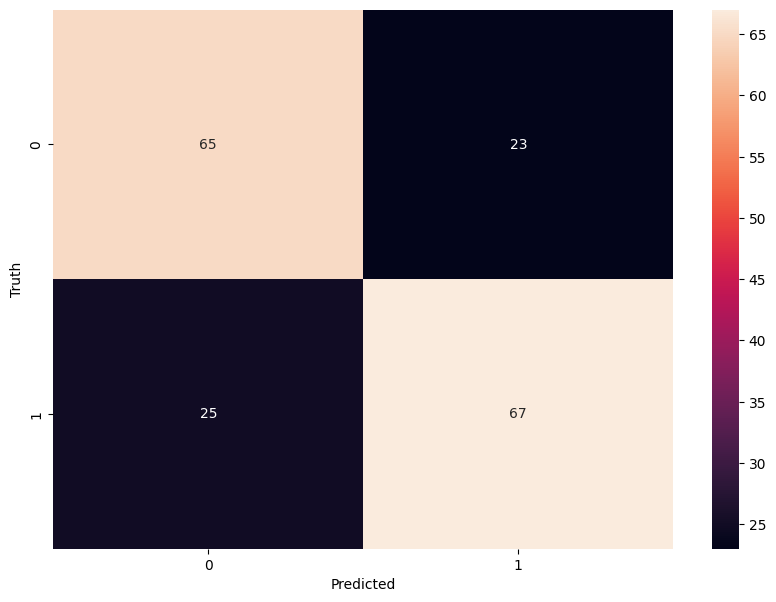

In [63]:
cmrf = confusion_matrix(predictions_rf,binary_test_labels)
plt.figure(figsize=(10,7))
sns.heatmap(cmrf,annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [64]:
print(classification_report(binary_test_labels,predictions_rf))

              precision    recall  f1-score   support

         0.0       0.74      0.72      0.73        90
         1.0       0.73      0.74      0.74        90

    accuracy                           0.73       180
   macro avg       0.73      0.73      0.73       180
weighted avg       0.73      0.73      0.73       180



In [66]:
filename = 'rfmodel.h5'
pickle.dump(rf_model,open(filename,'wb'))

In [67]:
loaded_rfmodel = pickle.load(open('rfmodel.h5','rb'))
real_img =cv2.imread('/content/drive/MyDrive/Dataset_sign/dataset4/real1/00203002.png')
real_img = cv2.cvtColor(real_img,cv2.COLOR_BGR2RGB)
real_img = cv2.resize(real_img,IMAGE_SHAPE)
real_img=real_img/255
real_img = real_img.reshape((1, 224, 224, 3))
real_img_reshaped = real_img.reshape((1, -1))
predcur = loaded_rfmodel.predict(real_img_reshaped)
if(predcur==0):
  print("Signature is real")
else:
  print("Signature is forged")

Signature is real


In [68]:
forge_img =cv2.imread('/content/drive/MyDrive/Dataset_sign/dataset4/forge/00301046.png')
forge_img = cv2.cvtColor(forge_img,cv2.COLOR_BGR2RGB)
forge_img = cv2.resize(forge_img,IMAGE_SHAPE)
forge_img=forge_img/255
forge_img = forge_img.reshape((1, 224, 224, 3))
forge_img_reshaped = forge_img.reshape((1, -1))
predcur=loaded_rfmodel.predict(forge_img_reshaped)
if(predcur==0):
  print("Signature is real")
else:
  print("Signature is forged")

Signature is forged


### Extreme Gradient Boosting

In [71]:
xgmodel = XGBClassifier(n_estimators=100)
xgmodel.fit(flattened_data,binary_labels)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [72]:
predictions_xg = xgmodel.predict(flattened_test)
# Evaluate the model
accuracy = accuracy_score(binary_test_labels, predictions_xg)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.72


Text(95.72222222222221, 0.5, 'Truth')

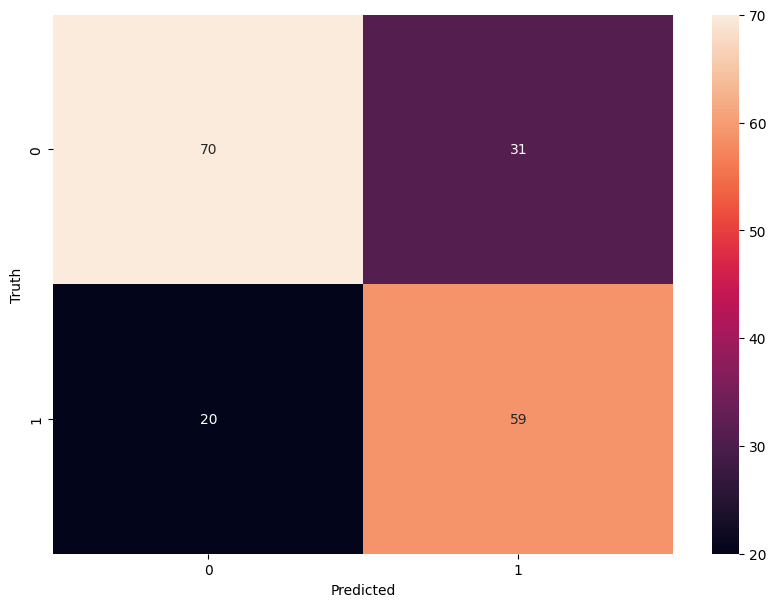

In [73]:
cmxg = confusion_matrix(predictions_xg,binary_test_labels)
plt.figure(figsize=(10,7))
sns.heatmap(cmxg,annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [74]:
print(classification_report(binary_test_labels,predictions_xg))

              precision    recall  f1-score   support

         0.0       0.69      0.78      0.73        90
         1.0       0.75      0.66      0.70        90

    accuracy                           0.72       180
   macro avg       0.72      0.72      0.72       180
weighted avg       0.72      0.72      0.72       180



In [75]:
pred = xgmodel.predict(flattened_test)
pred[:20]

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0])

In [76]:
for i in range(20):
  print('Person ',i,' \n Predicted: ',pred[i],' Actual: ',binary_test_labels[i],'path: ',test_paths[i])

Person  0  
 Predicted:  0  Actual:  0.0 path:  /content/drive/MyDrive/Dataset_sign/dataset4/real1/09203092.png
Person  1  
 Predicted:  0  Actual:  1.0 path:  /content/drive/MyDrive/Dataset_sign/dataset4/forge/06103016.png
Person  2  
 Predicted:  0  Actual:  0.0 path:  /content/drive/MyDrive/Dataset_sign/dataset4/real1/09304093.png
Person  3  
 Predicted:  0  Actual:  0.0 path:  /content/drive/MyDrive/Dataset_sign/dataset4/real1/09303093.png
Person  4  
 Predicted:  0  Actual:  0.0 path:  /content/drive/MyDrive/Dataset_sign/dataset4/real1/09202092.png
Person  5  
 Predicted:  0  Actual:  1.0 path:  /content/drive/MyDrive/Dataset_sign/dataset4/forge/03205084.png
Person  6  
 Predicted:  1  Actual:  1.0 path:  /content/drive/MyDrive/Dataset_sign/dataset4/forge/00304046.png
Person  7  
 Predicted:  0  Actual:  1.0 path:  /content/drive/MyDrive/Dataset_sign/dataset4/forge/01602089.png
Person  8  
 Predicted:  1  Actual:  1.0 path:  /content/drive/MyDrive/Dataset_sign/dataset4/forge/00405

In [77]:
import pickle
filename = 'xgbmodel.h5'
pickle.dump(xgmodel,open(filename,'wb'))

In [78]:
loaded_xgmodel = pickle.load(open('xgbmodel.h5','rb'))
real_img =cv2.imread('/content/drive/MyDrive/Dataset_sign/dataset4/real1/00203002.png')
real_img = cv2.cvtColor(real_img,cv2.COLOR_BGR2RGB)
real_img = cv2.resize(real_img,IMAGE_SHAPE)
real_img=real_img/255
real_img = real_img.reshape((1, 224, 224, 3))
real_img_reshaped = real_img.reshape((1, -1))
predcur = loaded_xgmodel.predict(real_img_reshaped)
if(predcur==0):
  print("Signature is real")
else:
  print("Signature is forged")

Signature is real


In [80]:
forge_img =cv2.imread('/content/drive/MyDrive/Dataset_sign/dataset4/forge/00301046.png')
forge_img = cv2.cvtColor(forge_img,cv2.COLOR_BGR2RGB)
forge_img = cv2.resize(forge_img,IMAGE_SHAPE)
forge_img=forge_img/255
forge_img = forge_img.reshape((1, 224, 224, 3))
forge_img_reshaped = forge_img.reshape((1, -1))
predcur=loaded_xgmodel.predict(forge_img_reshaped)
if(predcur==0):
  print("Signature is real")
else:
  print("Signature is forged")

Signature is forged


### Support Vector Machines

In [84]:
sv_model = svm.SVC(kernel='linear',gamma='auto')
sv_model.fit(flattened_data,binary_labels)

SVC(gamma='auto', kernel='linear')

In [85]:
predictions_svm = sv_model.predict(flattened_test)
# Evaluate the model
accuracy = accuracy_score(binary_test_labels, predictions_svm)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.71


Text(95.72222222222221, 0.5, 'Truth')

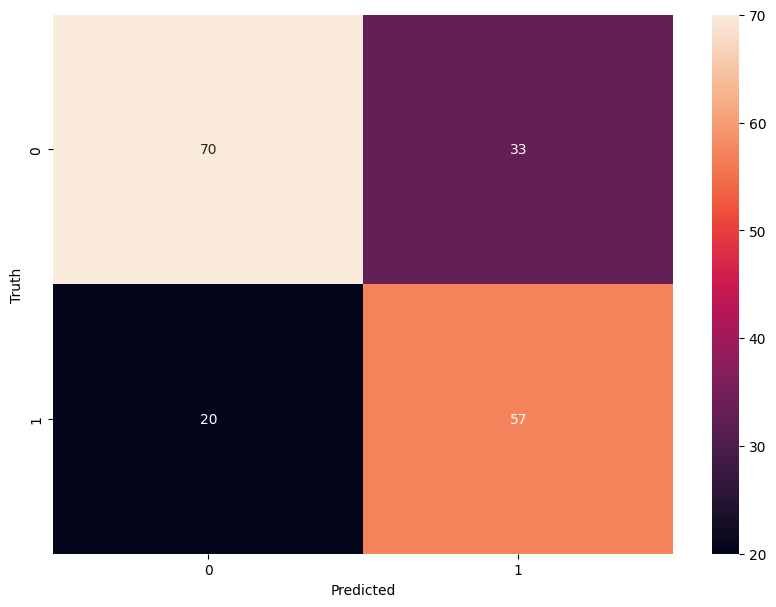

In [86]:
cmsv = confusion_matrix(predictions_svm,binary_test_labels)
plt.figure(figsize=(10,7))
sns.heatmap(cmsv,annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [88]:
print(classification_report(binary_test_labels,predictions_svm))

              precision    recall  f1-score   support

         0.0       0.68      0.78      0.73        90
         1.0       0.74      0.63      0.68        90

    accuracy                           0.71       180
   macro avg       0.71      0.71      0.70       180
weighted avg       0.71      0.71      0.70       180



In [89]:
pred = sv_model.predict(flattened_test)
pred[:20]

array([0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0.,
       0., 1., 0.], dtype=float32)

In [90]:
filename = 'svcmodel.h5'
pickle.dump(sv_model,open(filename,'wb'))

In [91]:
loaded_svmodel = pickle.load(open('svcmodel.h5','rb'))
real_img =cv2.imread('/content/drive/MyDrive/Dataset_sign/dataset4/real1/00203002.png')
real_img = cv2.cvtColor(real_img,cv2.COLOR_BGR2RGB)
real_img = cv2.resize(real_img,IMAGE_SHAPE)
real_img=real_img/255
real_img = real_img.reshape((1, 224, 224, 3))
real_img_reshaped = real_img.reshape((1, -1))
predcur = loaded_svmodel.predict(real_img_reshaped)
if(predcur==0):
  print("Signature is real")
else:
  print("Signature is forged")

Signature is real


In [92]:
forge_img =cv2.imread('/content/drive/MyDrive/Dataset_sign/dataset4/forge/00301046.png')
forge_img = cv2.cvtColor(forge_img,cv2.COLOR_BGR2RGB)
forge_img = cv2.resize(forge_img,IMAGE_SHAPE)
forge_img=forge_img/255
forge_img = forge_img.reshape((1, 224, 224, 3))
forge_img_reshaped = forge_img.reshape((1, -1))
predcur=loaded_svmodel.predict(forge_img_reshaped)
if(predcur==0):
  print("Signature is real")
else:
  print("Signature is forged")

Signature is forged
